# Experimentación - AGCRN



## 1. Obtención de datos



In [1]:

import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np

from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv
import itertools
import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid


from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch

from utils.models import AGCRNModel
from utils.trainer import  TrainerAGCRN
from utils.utils_graph import *
dtype = torch.float
device = torch.device("cpu")

In [12]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import MPNNLSTMModel

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="classification_type")
_,_,_ =loader.process()
limit = 300
dataset_full, situations_each = loader.get_dataset()
target_names = loader.target_names

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [43]:
def entrenar_y_evaluar_modelos_agcrn(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="Classification", name=None, target_names=None):
    resultados_list = []

    # Variables para guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    # Detalles del dataset
    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[0]
    n_features = dataset[0].x.shape[1]

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for hidden, embedding, k in tqdm(list(itertools.product(param_grid["hidden_size"], param_grid["embedding"], param_grid["k"]))):
        

        model = AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding,hidden_size = hidden, k=k, n_target=n_target, name="AGCRN", is_classification=True)
        trainer = TrainerAGCRN(model, dataset, device, f"./results/{problem}", dataloader_params, is_classification = True)

        losses, eval_losses, accs, precisions, recalls, f1s = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = trainer.test()

        results_intermedio = {
            "Embedding": embedding,
            "Hidden": hidden,   
            "k": k,
            "Loss_final": losses[-1],  # Usando el último valor de la lista, si es consistente con tus datos
            "Accuracy_eval": np.mean(accs),
            "Precision_eval": np.mean(precisions),
            "Recall_eval": np.mean(recalls),
            "F1_eval": np.mean(f1s),
            "Loss_eval": np.mean(eval_losses[-1]),  # Asumiendo que tienes evaluaciones periódicas como en regresión
            "Loss_tst": np.mean(test_loss),
            "Accuracy_tst": test_acc,
            "Precision_tst": test_precision,
            "Recall_tst": test_recall,
            "F1_tst": test_f1
        }
        
        resultados_list.append(results_intermedio)

        # Actualizar el mejor modelo si es necesario
        if np.mean(test_loss) < mejor_loss_test:
            mejor_loss_test = np.mean(test_loss)
            mejor_trainer = trainer
            mejores_parametros = {'hidden': hidden, "Embedding": embedding, 'K': k}
            mejores_resultados = results_intermedio

        print("Parámetros: ", hidden, k, embedding)
        print("Resultados: ", resultados_list[-1])

    resultados_df = pd.DataFrame(resultados_list)
    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_df


## Bucle rápido para ajustar y guardar resultados

In [47]:
from importlib import reload
import utils.models
utils.models = reload(utils.models)
from utils.models import AGCRNModel

In [48]:
from importlib import reload
import utils.trainer
utils.trainer = reload(utils.trainer)
from utils.trainer import TrainerAGCRN

In [50]:

param_grid = {
    "hidden_size": [10,20,50],
    "embedding": [3,5, 10, 15], 
    "k": [2, 3, 4]
}

dataloader_params = {
    "batch_size": 4,
    "data_split_ratio": [0.7, 0.15, 0.15],
    "seed": 42,
    "keep_same": True,
    "use_batch": True
}

num_early_stop = 10
num_epochs = 100
problem = "clasificacion"

mejor_trainer, mejores_parametros, mejores_resultados, resultados_df = entrenar_y_evaluar_modelos_agcrn(
    param_grid, 
    dataset_full, 
    dataloader_params, 
    num_early_stop, 
    num_epochs, 
    problem, "AGCRN",target_names)

  0%|          | 0/36 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 390
Validation dataset: 75
Test dataset: 84

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 97
DataLoader for val set:
Number of batches: 18
DataLoader for test set:
Number of batches: 21

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 1.5816 | Eval Loss: 1.5412 | Accuracy: 0.4028 | Precision: 0.0806 | Recall: 0.2000 | F1-Score: 0.1149 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 1.5579 | Eval Loss: 1.5132 | Accuracy: 0.4028 | Precision: 0.0806 | Recall: 0.2000 | F1-Score: 0.1149 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 1.5418 | Eval Loss: 1.4903 | Accuracy: 0.4028 | Precision: 0.0806 | Recall: 0.2000 | F1-Score: 0.1149 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 1.5297 | Eval Loss: 1.4738 | Accuracy: 0.4028 | Precision: 0.0806 | Recall: 0.2000 | F1-Score: 0.1149 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 1.5176 | Eval Loss: 1.4576 | 

  3%|▎         | 1/36 [01:27<51:13, 87.81s/it]

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.38      0.73      0.50        15
           2       0.43      0.33      0.38         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.56        84
   macro avg       0.43      0.53      0.47        84
weighted avg       0.45      0.56      0.49        84

preds:  ()
test loss: 1.360325, test accuracy: 0.5595, test precision: 0.4313, test recall: 0.5289, test F1-score: 0.4658
Parámetros:  10 2 3
Resultados:  {'Embedding': 3, 'Hidden': 10, 'k': 2, 'Loss_final': 1.2972253561019897, 'Accuracy_eval': 0.5665064102564101, 'Precision_eval': 0.27697298618343447, 'Recall_eval': 0.41682309732707606, 'F1_eval': 0.3231159276112126, 'Loss_eval': 1.3019384145736694, 'Loss_tst': 1.3603248596191406, 'Accuracy_tst': 0.5595238095238095, 'Precision_tst': 0.4313242538394668, 'R

  6%|▌         | 2/36 [03:20<57:54, 102.19s/it]

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       0.37      0.73      0.49        15
           2       1.00      0.11      0.20         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.57        84
   macro avg       0.54      0.53      0.44        84
weighted avg       0.51      0.57      0.48        84

preds:  ()
test loss: 1.355682, test accuracy: 0.5714, test precision: 0.5408, test recall: 0.5344, test F1-score: 0.4450
Parámetros:  10 3 3
Resultados:  {'Embedding': 3, 'Hidden': 10, 'k': 3, 'Loss_final': 1.3164836168289185, 'Accuracy_eval': 0.5758547008547008, 'Precision_eval': 0.27600483666063236, 'Recall_eval': 0.4295721961504454, 'F1_eval': 0.33292134361536735, 'Loss_eval': 1.3018372058868408, 'Loss_tst': 1.3556815385818481, 'Accuracy_tst': 0.5714285714285714, 'Precision_tst': 0.5408255933952528, 'R

  8%|▊         | 3/36 [05:07<57:29, 104.54s/it]

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       0.44      0.47      0.45        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.57      0.97      0.72        29

    accuracy                           0.56        84
   macro avg       0.33      0.49      0.39        84
weighted avg       0.37      0.56      0.44        84

preds:  ()
test loss: 1.374439, test accuracy: 0.5595, test precision: 0.3281, test recall: 0.4864, test F1-score: 0.3888
Parámetros:  10 4 3
Resultados:  {'Embedding': 3, 'Hidden': 10, 'k': 4, 'Loss_final': 1.3638447523117065, 'Accuracy_eval': 0.548344017094017, 'Precision_eval': 0.2308545969417304, 'Recall_eval': 0.37985558502799877, 'F1_eval': 0.2840738713650979, 'Loss_eval': 1.3206859827041626, 'Loss_tst': 1.3744393587112427, 'Accuracy_tst': 0.5595238095238095, 'Precision_tst': 0.3281015037593985, 'Rec

 11%|█         | 4/36 [06:31<51:33, 96.66s/it] 

              precision    recall  f1-score   support

           0       0.52      1.00      0.69        12
           1       0.39      0.73      0.51        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.73      0.83      0.77        29

    accuracy                           0.56        84
   macro avg       0.33      0.51      0.39        84
weighted avg       0.40      0.56      0.46        84

preds:  ()
test loss: 1.363903, test accuracy: 0.5595, test precision: 0.3284, test recall: 0.5122, test F1-score: 0.3943
Parámetros:  10 2 5
Resultados:  {'Embedding': 5, 'Hidden': 10, 'k': 2, 'Loss_final': 1.3073426485061646, 'Accuracy_eval': 0.5731837606837606, 'Precision_eval': 0.2845889285621909, 'Recall_eval': 0.43857942823460055, 'F1_eval': 0.3397460393161321, 'Loss_eval': 1.3018351793289185, 'Loss_tst': 1.3639030456542969, 'Accuracy_tst': 0.5595238095238095, 'Precision_tst': 0.32837380011293055, 'R

 14%|█▍        | 5/36 [08:15<51:12, 99.10s/it]

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       0.32      0.73      0.45        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.68      0.72      0.70        29

    accuracy                           0.52        84
   macro avg       0.33      0.49      0.38        84
weighted avg       0.38      0.52      0.43        84

preds:  ()
test loss: 1.386173, test accuracy: 0.5238, test precision: 0.3265, test recall: 0.4915, test F1-score: 0.3846
Parámetros:  10 3 5
Resultados:  {'Embedding': 5, 'Hidden': 10, 'k': 3, 'Loss_final': 1.342650294303894, 'Accuracy_eval': 0.5673076923076923, 'Precision_eval': 0.24575181675239127, 'Recall_eval': 0.39917023736652385, 'F1_eval': 0.30164539760553305, 'Loss_eval': 1.31233549118042, 'Loss_tst': 1.3861732482910156, 'Accuracy_tst': 0.5238095238095238, 'Precision_tst': 0.3265055427943673, 'Rec

 17%|█▋        | 6/36 [10:05<51:22, 102.75s/it]

              precision    recall  f1-score   support

           0       0.57      1.00      0.73        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.46      1.00      0.63        29

    accuracy                           0.49        84
   macro avg       0.21      0.40      0.27        84
weighted avg       0.24      0.49      0.32        84

preds:  ()
test loss: 1.416632, test accuracy: 0.4881, test precision: 0.2063, test recall: 0.4000, test F1-score: 0.2715
Parámetros:  10 4 5
Resultados:  {'Embedding': 5, 'Hidden': 10, 'k': 4, 'Loss_final': 1.4061787128448486, 'Accuracy_eval': 0.5459401709401709, 'Precision_eval': 0.20886944915370545, 'Recall_eval': 0.3585798816568047, 'F1_eval': 0.26143611464629884, 'Loss_eval': 1.3372055292129517, 'Loss_tst': 1.4166322946548462, 'Accuracy_tst': 0.4880952380952381, 'Precision_tst': 0.20634920634920634, '

 19%|█▉        | 7/36 [11:14<44:22, 91.80s/it] 

Epoch 52/100 | Train Loss: 1.3692 | Eval Loss: 1.3265 | Accuracy: 0.5833 | Precision: 0.3060 | Recall: 0.4375 | F1-Score: 0.3565 | LR: 0.0010 | 

==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        12
           1       0.37      0.47      0.41        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.61      0.97      0.75        29

    accuracy                           0.56        84
   macro avg       0.32      0.49      0.39        84
weighted avg       0.37      0.56      0.44        84

preds:  ()
test loss: 1.393177, test accuracy: 0.5595, test precision: 0.3217, test recall: 0.4864, test F1-score: 0.3865
Parámetros:  10 2 10
Resultados:  {'Embedding': 10, 'Hidden': 10, 'k': 2, 'Loss_final': 1.3692290782928467, 'Accuracy_eval': 0.547542735042735, 'Precision_eval': 0.2143048832107223, 'Recall_e

 22%|██▏       | 8/36 [12:45<42:41, 91.47s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.27        84
weighted avg       0.24      0.48      0.32        84

preds:  ()
test loss: 1.427498, test accuracy: 0.4762, test precision: 0.2160, test recall: 0.3833, test F1-score: 0.2726
Parámetros:  10 3 10
Resultados:  {'Embedding': 10, 'Hidden': 10, 'k': 3, 'Loss_final': 1.416955590248108, 'Accuracy_eval': 0.5483440170940169, 'Precision_eval': 0.20638640817011195, 'Recall_eval': 0.36124260355029575, 'F1_eval': 0.26211120005397687, 'Loss_eval': 1.3411619663238525, 'Loss_tst': 1.4274975061416626, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.21597892888498685

 25%|██▌       | 9/36 [14:18<41:27, 92.13s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  ()
test loss: 1.554554, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  10 4 10
Resultados:  {'Embedding': 10, 'Hidden': 10, 'k': 4, 'Loss_final': 1.5658364295959473, 'Accuracy_eval': 0.4027777777777778, 'Precision_eval': 0.08055555555555556, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.11485148514851487, 'Loss_eval': 1.5218154191970825, 'Loss_tst': 1.554553747177124, 'Accuracy_tst': 0.34523809523809523, 'Precision_tst': 0.06904761904761905

 28%|██▊       | 10/36 [15:26<36:35, 84.46s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.27        84
weighted avg       0.24      0.48      0.32        84

preds:  ()
test loss: 1.457507, test accuracy: 0.4762, test precision: 0.2160, test recall: 0.3833, test F1-score: 0.2726
Parámetros:  10 2 15
Resultados:  {'Embedding': 15, 'Hidden': 10, 'k': 2, 'Loss_final': 1.4569132328033447, 'Accuracy_eval': 0.47702991452991444, 'Precision_eval': 0.1477259409098422, 'Recall_eval': 0.2822485207100592, 'F1_eval': 0.190162849940868, 'Loss_eval': 1.3833463191986084, 'Loss_tst': 1.4575070142745972, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.21597892888498685, 

 31%|███       | 11/36 [16:58<36:12, 86.91s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.27        84
weighted avg       0.24      0.48      0.32        84

preds:  ()
test loss: 1.440575, test accuracy: 0.4762, test precision: 0.2160, test recall: 0.3833, test F1-score: 0.2726
Parámetros:  10 3 15
Resultados:  {'Embedding': 15, 'Hidden': 10, 'k': 3, 'Loss_final': 1.4358882904052734, 'Accuracy_eval': 0.518696581196581, 'Precision_eval': 0.18182656407044417, 'Recall_eval': 0.3284023668639052, 'F1_eval': 0.23272892259407207, 'Loss_eval': 1.3564133644104004, 'Loss_tst': 1.440575361251831, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.21597892888498685, 

 33%|███▎      | 12/36 [18:32<35:38, 89.10s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.35      1.00      0.51        29

    accuracy                           0.35        84
   macro avg       0.07      0.20      0.10        84
weighted avg       0.12      0.35      0.18        84

preds:  ()
test loss: 1.554480, test accuracy: 0.3452, test precision: 0.0690, test recall: 0.2000, test F1-score: 0.1027
Parámetros:  10 4 15
Resultados:  {'Embedding': 15, 'Hidden': 10, 'k': 4, 'Loss_final': 1.565955400466919, 'Accuracy_eval': 0.4027777777777778, 'Precision_eval': 0.08055555555555556, 'Recall_eval': 0.19999999999999993, 'F1_eval': 0.11485148514851487, 'Loss_eval': 1.5210644006729126, 'Loss_tst': 1.5544804334640503, 'Accuracy_tst': 0.34523809523809523, 'Precision_tst': 0.06904761904761905

 36%|███▌      | 13/36 [20:03<34:17, 89.46s/it]

              precision    recall  f1-score   support

           0       0.59      0.83      0.69        12
           1       0.38      0.73      0.50        15
           2       0.50      0.22      0.31         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.56        84
   macro avg       0.43      0.52      0.45        84
weighted avg       0.45      0.56      0.48        84

preds:  ()
test loss: 1.352571, test accuracy: 0.5595, test precision: 0.4347, test recall: 0.5233, test F1-score: 0.4519
Parámetros:  20 2 3
Resultados:  {'Embedding': 3, 'Hidden': 20, 'k': 2, 'Loss_final': 1.2742315530776978, 'Accuracy_eval': 0.577190170940171, 'Precision_eval': 0.319168855639198, 'Recall_eval': 0.42921966038676906, 'F1_eval': 0.34310138765275777, 'Loss_eval': 1.2910155057907104, 'Loss_tst': 1.3525710105895996, 'Accuracy_tst': 0.5595238095238095, 'Precision_tst': 0.43468559837728193, 'Re

 39%|███▉      | 14/36 [21:57<35:33, 96.98s/it]

              precision    recall  f1-score   support

           0       0.59      0.83      0.69        12
           1       0.38      0.73      0.50        15
           2       0.50      0.22      0.31         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.56        84
   macro avg       0.43      0.52      0.45        84
weighted avg       0.45      0.56      0.48        84

preds:  ()
test loss: 1.354310, test accuracy: 0.5595, test precision: 0.4347, test recall: 0.5233, test F1-score: 0.4519
Parámetros:  20 3 3
Resultados:  {'Embedding': 3, 'Hidden': 20, 'k': 3, 'Loss_final': 1.2868133783340454, 'Accuracy_eval': 0.5683760683760682, 'Precision_eval': 0.2759937155154956, 'Recall_eval': 0.413294339023782, 'F1_eval': 0.31985499828657804, 'Loss_eval': 1.28701913356781, 'Loss_tst': 1.354310393333435, 'Accuracy_tst': 0.5595238095238095, 'Precision_tst': 0.43468559837728193, 'Recal

 42%|████▏     | 15/36 [23:55<36:12, 103.43s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.35      0.73      0.48        15
           2       0.50      0.11      0.18         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.56        84
   macro avg       0.44      0.52      0.44        84
weighted avg       0.45      0.56      0.48        84

preds:  ()
test loss: 1.371416, test accuracy: 0.5595, test precision: 0.4416, test recall: 0.5177, test F1-score: 0.4361
Parámetros:  20 4 3
Resultados:  {'Embedding': 3, 'Hidden': 20, 'k': 4, 'Loss_final': 1.317557454109192, 'Accuracy_eval': 0.5641025641025641, 'Precision_eval': 0.2645435345243792, 'Recall_eval': 0.4149856038450203, 'F1_eval': 0.3194709228488889, 'Loss_eval': 1.3037747144699097, 'Loss_tst': 1.3714163303375244, 'Accuracy_tst': 0.5595238095238095, 'Precision_tst': 0.44155597722960155, 'Rec

 44%|████▍     | 16/36 [25:28<33:21, 100.10s/it]

              precision    recall  f1-score   support

           0       0.55      0.92      0.69        12
           1       0.38      0.73      0.50        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.55        84
   macro avg       0.33      0.50      0.39        84
weighted avg       0.39      0.55      0.45        84

preds:  ()
test loss: 1.355116, test accuracy: 0.5476, test precision: 0.3270, test recall: 0.4955, test F1-score: 0.3899
Parámetros:  20 2 5
Resultados:  {'Embedding': 5, 'Hidden': 20, 'k': 2, 'Loss_final': 1.3163657188415527, 'Accuracy_eval': 0.5715811965811965, 'Precision_eval': 0.2839877952389902, 'Recall_eval': 0.42270738398059343, 'F1_eval': 0.3291176062351556, 'Loss_eval': 1.3017470836639404, 'Loss_tst': 1.3551157712936401, 'Accuracy_tst': 0.5476190476190477, 'Precision_tst': 0.32703853955375256, 'R

 47%|████▋     | 17/36 [27:21<32:58, 104.15s/it]

              precision    recall  f1-score   support

           0       0.53      0.83      0.65        12
           1       0.38      0.73      0.50        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.54        84
   macro avg       0.32      0.48      0.38        84
weighted avg       0.39      0.54      0.44        84

preds:  ()
test loss: 1.360476, test accuracy: 0.5357, test precision: 0.3223, test recall: 0.4789, test F1-score: 0.3814
Parámetros:  20 3 5
Resultados:  {'Embedding': 5, 'Hidden': 20, 'k': 3, 'Loss_final': 1.28725266456604, 'Accuracy_eval': 0.5715811965811964, 'Precision_eval': 0.2841175694573479, 'Recall_eval': 0.4240540479267269, 'F1_eval': 0.3329394563225909, 'Loss_eval': 1.2970082759857178, 'Loss_tst': 1.360475778579712, 'Accuracy_tst': 0.5357142857142857, 'Precision_tst': 0.3223016974484894, 'Recall

 50%|█████     | 18/36 [29:18<32:22, 107.89s/it]

              precision    recall  f1-score   support

           0       0.55      0.92      0.69        12
           1       0.38      0.73      0.50        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.55        84
   macro avg       0.33      0.50      0.39        84
weighted avg       0.39      0.55      0.45        84

preds:  ()
test loss: 1.381956, test accuracy: 0.5476, test precision: 0.3270, test recall: 0.4955, test F1-score: 0.3899
Parámetros:  20 4 5
Resultados:  {'Embedding': 5, 'Hidden': 20, 'k': 4, 'Loss_final': 1.3392657041549683, 'Accuracy_eval': 0.5651709401709402, 'Precision_eval': 0.23293035896374487, 'Recall_eval': 0.38880047155909225, 'F1_eval': 0.28961176732555466, 'Loss_eval': 1.3132069110870361, 'Loss_tst': 1.3819563388824463, 'Accuracy_tst': 0.5476190476190477, 'Precision_tst': 0.32703853955375256, 

 53%|█████▎    | 19/36 [30:53<29:28, 104.03s/it]

              precision    recall  f1-score   support

           0       0.67      1.00      0.80        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.44      1.00      0.61        29

    accuracy                           0.49        84
   macro avg       0.22      0.40      0.28        84
weighted avg       0.25      0.49      0.33        84

preds:  ()
test loss: 1.408509, test accuracy: 0.4881, test precision: 0.2212, test recall: 0.4000, test F1-score: 0.2821
Parámetros:  20 2 10
Resultados:  {'Embedding': 10, 'Hidden': 20, 'k': 2, 'Loss_final': 1.4009531736373901, 'Accuracy_eval': 0.5523504273504273, 'Precision_eval': 0.20881955643095862, 'Recall_eval': 0.365680473372781, 'F1_eval': 0.26536685102739893, 'Loss_eval': 1.3466888666152954, 'Loss_tst': 1.4085092544555664, 'Accuracy_tst': 0.4880952380952381, 'Precision_tst': 0.2212121212121212, '

 56%|█████▌    | 20/36 [32:49<28:41, 107.57s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.27        84
weighted avg       0.24      0.48      0.32        84

preds:  ()
test loss: 1.420829, test accuracy: 0.4762, test precision: 0.2160, test recall: 0.3833, test F1-score: 0.2726
Parámetros:  20 3 10
Resultados:  {'Embedding': 10, 'Hidden': 20, 'k': 3, 'Loss_final': 1.408037781715393, 'Accuracy_eval': 0.5528846153846152, 'Precision_eval': 0.2095454509917882, 'Recall_eval': 0.3662721893491124, 'F1_eval': 0.2661443912587958, 'Loss_eval': 1.340217113494873, 'Loss_tst': 1.4208285808563232, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.21597892888498685, 'R

 58%|█████▊    | 21/36 [34:57<28:27, 113.84s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.27        84
weighted avg       0.24      0.48      0.32        84

preds:  ()
test loss: 1.451995, test accuracy: 0.4762, test precision: 0.2160, test recall: 0.3833, test F1-score: 0.2726
Parámetros:  20 4 10
Resultados:  {'Embedding': 10, 'Hidden': 20, 'k': 4, 'Loss_final': 1.4472203254699707, 'Accuracy_eval': 0.5197649572649571, 'Precision_eval': 0.18189798346912386, 'Recall_eval': 0.32958579881656797, 'F1_eval': 0.23328342086936452, 'Loss_eval': 1.3715273141860962, 'Loss_tst': 1.4519946575164795, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.2159789288849868

 61%|██████    | 22/36 [36:34<25:21, 108.65s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.27        84
weighted avg       0.24      0.48      0.32        84

preds:  ()
test loss: 1.467974, test accuracy: 0.4762, test precision: 0.2160, test recall: 0.3833, test F1-score: 0.2726
Parámetros:  20 2 15
Resultados:  {'Embedding': 15, 'Hidden': 20, 'k': 2, 'Loss_final': 1.4657204151153564, 'Accuracy_eval': 0.4687499999999999, 'Precision_eval': 0.1387540389389556, 'Recall_eval': 0.2730769230769231, 'F1_eval': 0.18224587764047406, 'Loss_eval': 1.3881642818450928, 'Loss_tst': 1.4679738283157349, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.21597892888498685,

 64%|██████▍   | 23/36 [38:29<23:59, 110.76s/it]

              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.28        84
weighted avg       0.25      0.48      0.32        84

preds:  ()
test loss: 1.511038, test accuracy: 0.4762, test precision: 0.2228, test recall: 0.3833, test F1-score: 0.2767
Parámetros:  20 3 15
Resultados:  {'Embedding': 15, 'Hidden': 20, 'k': 3, 'Loss_final': 1.512864589691162, 'Accuracy_eval': 0.41185897435897423, 'Precision_eval': 0.09012587117751655, 'Recall_eval': 0.21005917159763318, 'F1_eval': 0.1250480397721797, 'Loss_eval': 1.445648193359375, 'Loss_tst': 1.511038064956665, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.22279411764705884, 

 67%|██████▋   | 24/36 [40:41<23:24, 117.04s/it]

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.42      1.00      0.59        29

    accuracy                           0.46        84
   macro avg       0.22      0.37      0.27        84
weighted avg       0.24      0.46      0.31        84

preds:  ()
test loss: 1.514312, test accuracy: 0.4643, test precision: 0.2174, test recall: 0.3667, test F1-score: 0.2665
Parámetros:  20 4 15
Resultados:  {'Embedding': 15, 'Hidden': 20, 'k': 4, 'Loss_final': 1.5163116455078125, 'Accuracy_eval': 0.4155982905982907, 'Precision_eval': 0.09430210755945091, 'Recall_eval': 0.21420118343195269, 'F1_eval': 0.12956419355770754, 'Loss_eval': 1.4491276741027832, 'Loss_tst': 1.514311671257019, 'Accuracy_tst': 0.4642857142857143, 'Precision_tst': 0.21739130434782608,

 69%|██████▉   | 25/36 [42:49<22:03, 120.28s/it]

              precision    recall  f1-score   support

           0       0.61      0.92      0.73        12
           1       0.38      0.73      0.50        15
           2       0.67      0.22      0.33         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.57        84
   macro avg       0.47      0.54      0.47        84
weighted avg       0.47      0.57      0.49        84

preds:  ()
test loss: 1.349166, test accuracy: 0.5714, test precision: 0.4726, test recall: 0.5400, test F1-score: 0.4657
Parámetros:  50 2 3
Resultados:  {'Embedding': 3, 'Hidden': 50, 'k': 2, 'Loss_final': 1.2533435821533203, 'Accuracy_eval': 0.5779914529914529, 'Precision_eval': 0.3300640657976915, 'Recall_eval': 0.44177378766238173, 'F1_eval': 0.36589044007301796, 'Loss_eval': 1.2956922054290771, 'Loss_tst': 1.3491655588150024, 'Accuracy_tst': 0.5714285714285714, 'Precision_tst': 0.4725940951093081, 'R

 72%|███████▏  | 26/36 [45:39<22:33, 135.31s/it]

              precision    recall  f1-score   support

           0       0.59      0.83      0.69        12
           1       0.38      0.73      0.50        15
           2       0.50      0.22      0.31         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.56        84
   macro avg       0.43      0.52      0.45        84
weighted avg       0.45      0.56      0.48        84

preds:  ()
test loss: 1.353771, test accuracy: 0.5595, test precision: 0.4347, test recall: 0.5233, test F1-score: 0.4519
Parámetros:  50 3 3
Resultados:  {'Embedding': 3, 'Hidden': 50, 'k': 3, 'Loss_final': 1.2650700807571411, 'Accuracy_eval': 0.5841346153846154, 'Precision_eval': 0.3404096062344799, 'Recall_eval': 0.44215806298034405, 'F1_eval': 0.35991129452809145, 'Loss_eval': 1.2874919176101685, 'Loss_tst': 1.3537710905075073, 'Accuracy_tst': 0.5595238095238095, 'Precision_tst': 0.43468559837728193, '

 75%|███████▌  | 27/36 [49:14<23:52, 159.20s/it]

              precision    recall  f1-score   support

           0       0.61      0.92      0.73        12
           1       0.37      0.73      0.49        15
           2       0.50      0.11      0.18         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.56        84
   macro avg       0.44      0.52      0.43        84
weighted avg       0.45      0.56      0.47        84

preds:  ()
test loss: 1.353925, test accuracy: 0.5595, test precision: 0.4367, test recall: 0.5177, test F1-score: 0.4332
Parámetros:  50 4 3
Resultados:  {'Embedding': 3, 'Hidden': 50, 'k': 4, 'Loss_final': 1.2900890111923218, 'Accuracy_eval': 0.5771901709401709, 'Precision_eval': 0.2989451378792946, 'Recall_eval': 0.4251207236618377, 'F1_eval': 0.33511013539983925, 'Loss_eval': 1.29500150680542, 'Loss_tst': 1.353925108909607, 'Accuracy_tst': 0.5595238095238095, 'Precision_tst': 0.4367320261437909, 'Recal

 78%|███████▊  | 28/36 [51:25<20:06, 150.84s/it]

              precision    recall  f1-score   support

           0       0.55      0.92      0.69        12
           1       0.38      0.73      0.50        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.55        84
   macro avg       0.33      0.50      0.39        84
weighted avg       0.39      0.55      0.45        84

preds:  ()
test loss: 1.344170, test accuracy: 0.5476, test precision: 0.3270, test recall: 0.4955, test F1-score: 0.3899
Parámetros:  50 2 5
Resultados:  {'Embedding': 5, 'Hidden': 50, 'k': 2, 'Loss_final': 1.2540515661239624, 'Accuracy_eval': 0.5702457264957265, 'Precision_eval': 0.31074132889367895, 'Recall_eval': 0.4309676029835181, 'F1_eval': 0.34979721715416534, 'Loss_eval': 1.2938288450241089, 'Loss_tst': 1.3441698551177979, 'Accuracy_tst': 0.5476190476190477, 'Precision_tst': 0.32703853955375256, '

 81%|████████  | 29/36 [54:23<18:32, 158.99s/it]

              precision    recall  f1-score   support

           0       0.56      0.75      0.64        12
           1       0.38      0.73      0.50        15
           2       0.40      0.22      0.29         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.55        84
   macro avg       0.41      0.51      0.44        84
weighted avg       0.43      0.55      0.47        84

preds:  ()
test loss: 1.352435, test accuracy: 0.5476, test precision: 0.4095, test recall: 0.5066, test F1-score: 0.4381
Parámetros:  50 3 5
Resultados:  {'Embedding': 5, 'Hidden': 50, 'k': 3, 'Loss_final': 1.2736432552337646, 'Accuracy_eval': 0.5766559829059829, 'Precision_eval': 0.3029838263228305, 'Recall_eval': 0.4264333809426647, 'F1_eval': 0.34037375247506463, 'Loss_eval': 1.2935384511947632, 'Loss_tst': 1.3524349927902222, 'Accuracy_tst': 0.5476190476190477, 'Precision_tst': 0.4095385395537526, 'Re

 83%|████████▎ | 30/36 [58:02<17:40, 176.82s/it]

              precision    recall  f1-score   support

           0       0.55      0.92      0.69        12
           1       0.38      0.73      0.50        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.55        84
   macro avg       0.33      0.50      0.39        84
weighted avg       0.39      0.55      0.45        84

preds:  ()
test loss: 1.370222, test accuracy: 0.5476, test precision: 0.3270, test recall: 0.4955, test F1-score: 0.3899
Parámetros:  50 4 5
Resultados:  {'Embedding': 5, 'Hidden': 50, 'k': 4, 'Loss_final': 1.336487889289856, 'Accuracy_eval': 0.5582264957264956, 'Precision_eval': 0.233475939990035, 'Recall_eval': 0.3815026411843388, 'F1_eval': 0.2870783130344201, 'Loss_eval': 1.315244436264038, 'Loss_tst': 1.3702224493026733, 'Accuracy_tst': 0.5476190476190477, 'Precision_tst': 0.32703853955375256, 'Recal

 86%|████████▌ | 31/36 [1:00:29<13:59, 167.89s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.33      0.67      0.44        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.67      0.83      0.74        29

    accuracy                           0.54        84
   macro avg       0.33      0.48      0.39        84
weighted avg       0.38      0.54      0.44        84

preds:  ()
test loss: 1.377256, test accuracy: 0.5357, test precision: 0.3294, test recall: 0.4822, test F1-score: 0.3883
Parámetros:  50 2 10
Resultados:  {'Embedding': 10, 'Hidden': 50, 'k': 2, 'Loss_final': 1.3395012617111206, 'Accuracy_eval': 0.5705128205128205, 'Precision_eval': 0.25557153017409945, 'Recall_eval': 0.40546373755922815, 'F1_eval': 0.30842845138678354, 'Loss_eval': 1.3272695541381836, 'Loss_tst': 1.3772563934326172, 'Accuracy_tst': 0.5357142857142857, 'Precision_tst': 0.32941176470588235

 89%|████████▉ | 32/36 [1:03:51<11:52, 178.11s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.44      1.00      0.61        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.27        84
weighted avg       0.24      0.48      0.32        84

preds:  ()
test loss: 1.411236, test accuracy: 0.4762, test precision: 0.2173, test recall: 0.3833, test F1-score: 0.2738
Parámetros:  50 3 10
Resultados:  {'Embedding': 10, 'Hidden': 50, 'k': 3, 'Loss_final': 1.3916212320327759, 'Accuracy_eval': 0.5606303418803418, 'Precision_eval': 0.2199364263043509, 'Recall_eval': 0.37485207100591705, 'F1_eval': 0.27417564189062277, 'Loss_eval': 1.3388274908065796, 'Loss_tst': 1.411236047744751, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.21729055258467023,

 92%|█████████▏| 33/36 [1:08:00<09:58, 199.47s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.27        84
weighted avg       0.24      0.48      0.32        84

preds:  ()
test loss: 1.421184, test accuracy: 0.4762, test precision: 0.2160, test recall: 0.3833, test F1-score: 0.2726
Parámetros:  50 4 10
Resultados:  {'Embedding': 10, 'Hidden': 50, 'k': 4, 'Loss_final': 1.413070797920227, 'Accuracy_eval': 0.5550213675213674, 'Precision_eval': 0.21171476607770903, 'Recall_eval': 0.3686390532544378, 'F1_eval': 0.26845035536876655, 'Loss_eval': 1.3364996910095215, 'Loss_tst': 1.4211839437484741, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.21597892888498685,

 94%|█████████▍| 34/36 [1:10:34<06:11, 185.75s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.27        84
weighted avg       0.24      0.48      0.32        84

preds:  ()
test loss: 1.427269, test accuracy: 0.4762, test precision: 0.2160, test recall: 0.3833, test F1-score: 0.2726
Parámetros:  50 2 15
Resultados:  {'Embedding': 15, 'Hidden': 50, 'k': 2, 'Loss_final': 1.419069766998291, 'Accuracy_eval': 0.5528846153846152, 'Precision_eval': 0.20946681273435014, 'Recall_eval': 0.3662721893491124, 'F1_eval': 0.266098574705678, 'Loss_eval': 1.340748906135559, 'Loss_tst': 1.4272687435150146, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.21597892888498685, 'R

 97%|█████████▋| 35/36 [1:14:05<03:13, 193.27s/it]

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.27        84
weighted avg       0.24      0.48      0.32        84

preds:  ()
test loss: 1.435799, test accuracy: 0.4762, test precision: 0.2160, test recall: 0.3833, test F1-score: 0.2726
Parámetros:  50 3 15
Resultados:  {'Embedding': 15, 'Hidden': 50, 'k': 3, 'Loss_final': 1.4343866109848022, 'Accuracy_eval': 0.5069444444444443, 'Precision_eval': 0.17148179355057416, 'Recall_eval': 0.3153846153846154, 'F1_eval': 0.22086018100038057, 'Loss_eval': 1.3515961170196533, 'Loss_tst': 1.435799241065979, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.21597892888498685,

100%|██████████| 36/36 [1:18:26<00:00, 130.75s/it]

              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.43      1.00      0.60        29

    accuracy                           0.48        84
   macro avg       0.22      0.38      0.28        84
weighted avg       0.25      0.48      0.32        84

preds:  ()
test loss: 1.470539, test accuracy: 0.4762, test precision: 0.2228, test recall: 0.3833, test F1-score: 0.2767
Parámetros:  50 4 15
Resultados:  {'Embedding': 15, 'Hidden': 50, 'k': 4, 'Loss_final': 1.4668629169464111, 'Accuracy_eval': 0.4778311965811965, 'Precision_eval': 0.14944156814202075, 'Recall_eval': 0.28313609467455625, 'F1_eval': 0.19286520012766678, 'Loss_eval': 1.389750361442566, 'Loss_tst': 1.4705387353897095, 'Accuracy_tst': 0.47619047619047616, 'Precision_tst': 0.22279411764705884


==================== TEST INFO ===================

              precision    recall  f1-score   support

           0       0.55      0.92      0.69        12
           1       0.38      0.73      0.50        15
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        19
           4       0.71      0.83      0.76        29

    accuracy                           0.55        84
   macro avg       0.33      0.50      0.39        84
weighted avg       0.39      0.55      0.45        84

preds:  ()
test loss: 1.344170, test accuracy: 0.5476, test precision: 0.3270, test recall: 0.4955, test F1-score: 0.3899


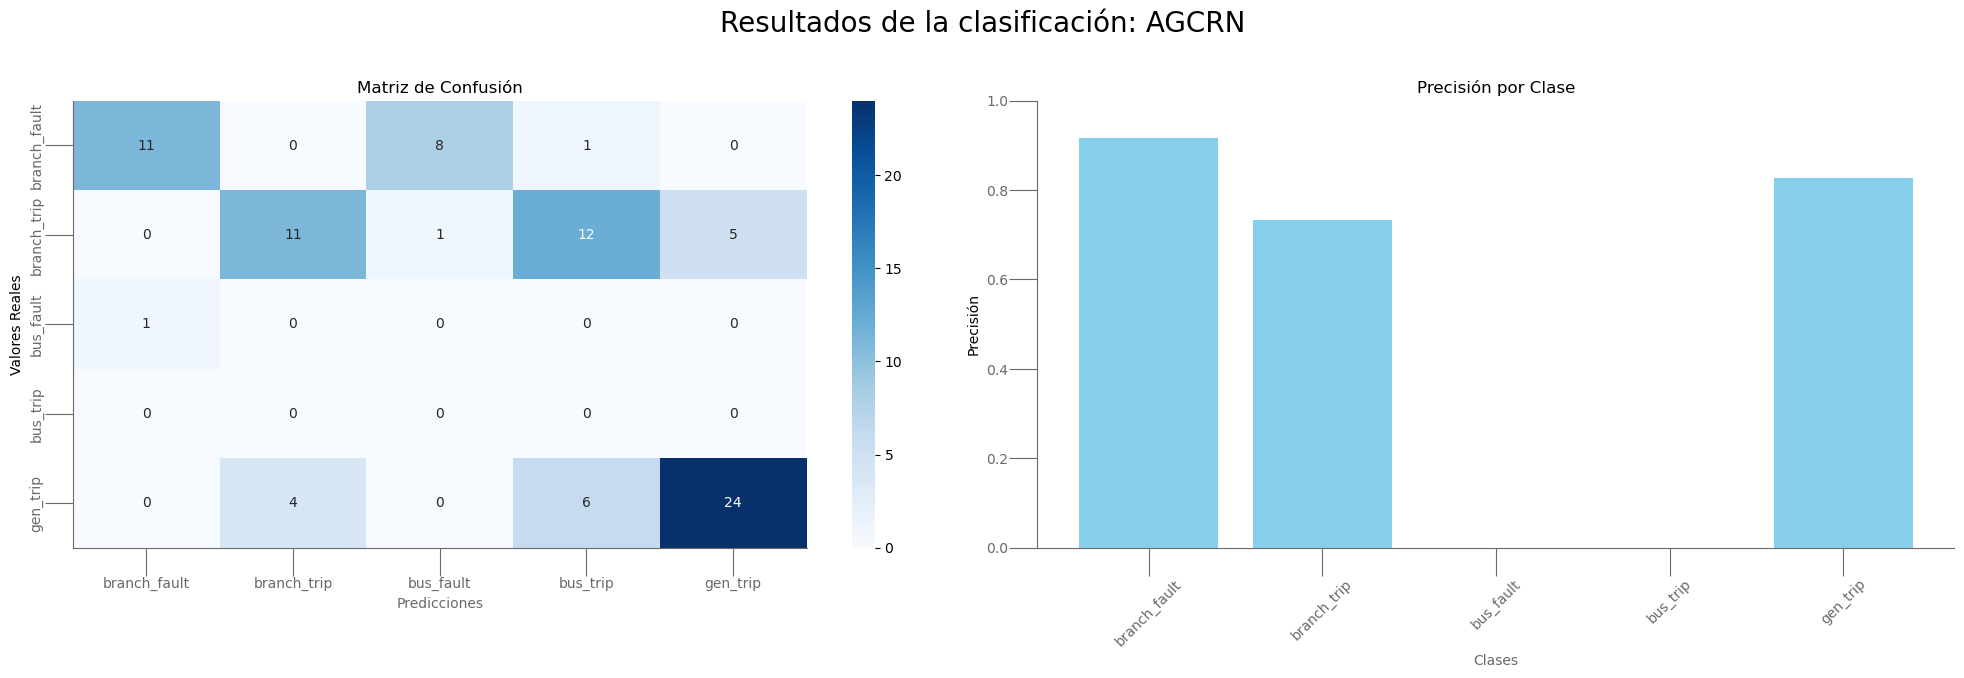

In [51]:
test_acc, test_precision, test_recall, test_f1, test_loss, preds, real = mejor_trainer.test()
plot_clasificacion(real, preds, target_names, "AGCRN")

In [52]:
name_model ="AGCRN"
results_save_path = "../experimentos_split/results"

path_save_experiment = results_save_path+f"/{problem}"+ f"/ajustes/{name_model}_results.csv"
resultados_df.to_csv(path_save_experiment, index=False)
mejor_trainer.save_model(path_save_experiment=path_save_experiment, params = mejores_parametros)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                  Params  \
0     MPNN_LSTM     {'Hidden Size': 64, 'Dropout': 0.2}   
1    LSTM_BATCH       {'Hidden Size': 150, 'Layers': 1}   
2  LSTM_NOBATCH       {'Hidden Size': 150, 'Layers': 2}   
3         AGCRN  {'hidden': 50, 'Embedding': 5, 'K': 2}   

                      Fichero_resultados_experimento  Loss_tst  Loss_eval  \
0  ../experimentos_split/results/clasificacion/aj...  1.348738   1.286855   
1  ../experimentos_split/results/clasificacion/aj...  1.163377   1.213140   
2  ../experimentos_split/results/clasificacion/aj...  1.160608   1.194841   
3  ../experimentos_split/results/clasificacion/aj...  1.344170   1.293829   

   Loss_final  Accuracy_eval  Precision_eval  Recall_eval   F1_eval  \
0    1.270143       0.600000        0.438630     0.498128  0.435153   
1    1.075731       0.671875        0.630667     0.671140  0.635028   
2    1.076455       0.706667        0.666